Project : CamemBERT  
Unit : Advanced Machine Learning   
MSc. Intelligent systems engineering  
SORBONNE UNIVERSITÉ  

--- Students ---  
@SSivanesan - Shivamshan SIVANESAN  
@Emirtas7 - Emir TAS  
@KishanthanKingston - Kishanthan KINGSTON  
code inspiré de :
- https://huggingface.co/blog/how-to-train
- https://github.com/theartificialguy/NLP-with-Deep-Learning/blob/master/BERT/Fine%20Tune%20BERT/fine_tuning_bert_with_MLM.ipynb
- https://github.com/mdabashar/Deep-Learning-Algorithms/blob/master/Retraining%20RoBERTa%20for%20MLM.ipynb

#### Roberta pré-entrainé sur une petite part de notre base de données

In [1]:
from transformers import RobertaTokenizerFast, RobertaForMaskedLM,AutoTokenizer 
from transformers import LineByLineTextDataset, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
from utilis.utilis import PreProcessing
import torch
from torch.utils.data import Dataset

2023-12-14 11:09:58.271065: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-14 11:10:00.320140: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-12-14 11:10:00.320320: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-12-14 11:10:00.320333: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

In [2]:
file_path = 'Evaluation_dataset/UD_French-GSD/fr_gsd-ud-train.txt'
pre_process = PreProcessing(file_path)
input_texts = pre_process.read_dataset() 
# tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', max_len=512)
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

In [3]:

class MyDataset(Dataset):
    def __init__(self, texts, tokenizer, block_size:int = 128):
        self.tokenizer = tokenizer
        self.inputs = []
        self.targets = []

        for text in texts:
            inputs = tokenizer(text, truncation=True, max_length=512, padding='max_length') 
            examples = {"input_ids": inputs.input_ids}
            grouped_examples = self.group_texts(examples, block_size)
            self.inputs.extend(grouped_examples["input_ids"])
            self.targets.extend(grouped_examples["labels"])

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        item = {"input_ids": self.inputs[idx], "labels": self.targets[idx]}
        return item

    def group_texts(self,examples, block_size):
        concatenated_examples = {k: examples[k] for k in examples.keys()}
        total_length = len(concatenated_examples[list(examples.keys())[0]])
        if total_length >= block_size:
            total_length = (total_length // block_size) * block_size
        result = {
            k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
            for k, t in concatenated_examples.items()
        }
        result["labels"] = result["input_ids"].copy()
        return result

dataset = MyDataset(input_texts, tokenizer)

In [4]:
model = RobertaForMaskedLM.from_pretrained('roberta-base')

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

training_args = TrainingArguments(
    output_dir="./roberta-mlm",
    overwrite_output_dir=True,
    num_train_epochs=100,
    per_device_train_batch_size=64,
    save_steps=10,
    save_total_limit=50,
    seed=1
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
)

In [5]:
trainer_result = trainer.train()
trainer.save_model("./roberta-retrained")

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,2.977500
1000,2.674000
1500,2.602000
2000,2.424000
2500,2.377300
3000,2.341900
3500,2.240000
4000,2.231200
4500,2.214000
5000,2.140800


In [ ]:
from transformers import pipeline

fill_mask = pipeline(
    "fill-mask",
    model="./roberta-retrained",
    tokenizer="roberta-base"
)
fill_mask("Je prépare un <mask> au chocolat.")

[{'score': 0.6465614438056946,
  'token': 17927,
  'token_str': ' dessert',
  'sequence': 'Je prépare un dessert au chocolat.'},
 {'score': 0.06801274418830872,
  'token': 2391,
  'token_str': ' restaurant',
  'sequence': 'Je prépare un restaurant au chocolat.'},
 {'score': 0.058270663022994995,
  'token': 5765,
  'token_str': ' menu',
  'sequence': 'Je prépare un menu au chocolat.'},
 {'score': 0.02214585803449154,
  'token': 4206,
  'token_str': ' excellent',
  'sequence': 'Je prépare un excellent au chocolat.'},
 {'score': 0.017763499170541763,
  'token': 11658,
  'token_str': ' satisfaction',
  'sequence': 'Je prépare un satisfaction au chocolat.'}]

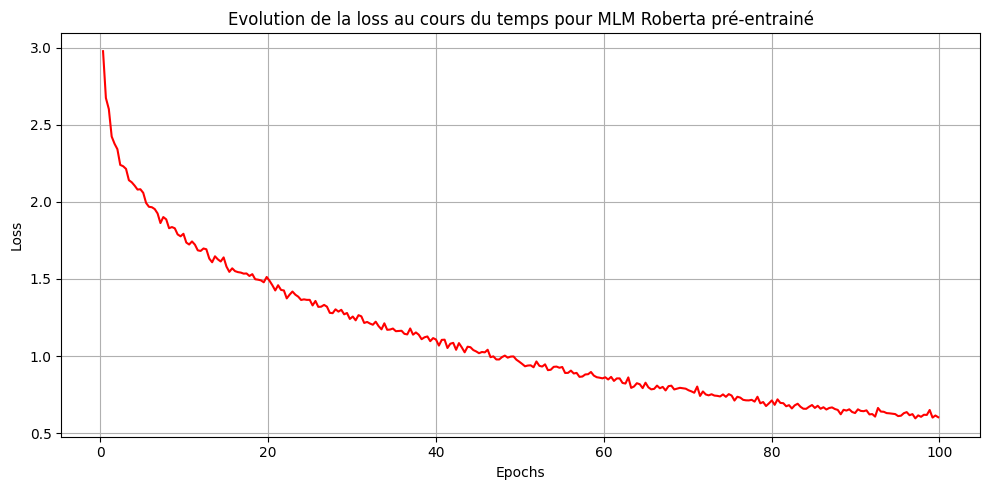

In [15]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history

losses = [log['loss'] for log in logs if 'loss' in log]
epochs = [log['epoch'] for log in logs if 'loss' in log]

plt.figure(figsize=(10, 5))
plt.plot(epochs, losses, color = 'r')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolution de la loss au cours du temps pour MLM Roberta pré-entrainé')
plt.tight_layout()
plt.show()